# Определение региона для бурения новой скважины по прогнозируемой прибыли
**Проект №7 Яндекс.Практикум - Data Science**

## Описание проекта

**Исходные данные:**

Пробы нефти в трёх регионах и характеристики для каждой скважины в регионе.

**Цель проекта:**

Построить модель для определения региона, где добыча принесёт наибольшую прибыль. Использовать при анализе возможной прибыли и рисков технику Bootstrap.

**Условия задачи:**

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

### Структура проекта
* [1. Загрузка, анализ и подготовка данных](#start)
* [2. Обучение и проверка модели](#model)
    * [2.1 Обучение модели и предсказание на валидационной выборке](#predict)
    * [2.2 Анализ результатов обучения](#analysis)
* [3. Расчёт прибыли](#earnings)
    * [3.1 Подготовка к расчёту прибыли](#earnings_1)
    * [3.2 Расчёт прибыли и рисков](#earnings_1)
* [4. Общий вывод](#conclusion)

<a id="start"></a>
## 1. Загрузка, анализ и подготовка данных

#### Импортируем необходимые библиотеки

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
dataset_names = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']
data = []

try:
    for dataset in dataset_names:
        data.append(pd.read_csv(f'./datasets/{dataset}', sep=','))
        print(f'Прочитан файл с данными: "./datasets/{dataset}"')
except:
    try:
        for dataset in dataset_names:
            data = pd.read_csv(f'/datasets/{dataset_name}', sep=',') # yandex.praktikum
            print(f'Прочитан файл с данными: "/datasets/{dataset_name}"')
    except Exception as err:
        print(repr(err))

Прочитан файл с данными: "./datasets/geo_data_0.csv"
Прочитан файл с данными: "./datasets/geo_data_1.csv"
Прочитан файл с данными: "./datasets/geo_data_2.csv"


In [3]:
data[0].head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data[1].head(5)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
data[2].head(5)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


#### Проверим есть ли у нас пропуски в данных

In [6]:
data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### Описание данных

**Признаки**
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

#### Проверим повторяется ли индентификатор скважины

In [9]:
data[0]['id'].value_counts()

Tdehs    2
AGS9W    2
fiKDv    2
bxg6G    2
TtcGQ    2
        ..
uhbGB    1
eNlGM    1
br8uY    1
5tIi9    1
4ePuU    1
Name: id, Length: 99990, dtype: int64

In [10]:
data[0].loc[data[0]['id'] == '74z30']

,id,f0,f1,f2,product
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327


К сожалению, мы не знаем причин появления нескольких строк данных по одним и тем же скважинам и не знаем можем ли мы объединить признаки эти скважин, поэтому избавимся от данных по этим скважинам

In [11]:
for i in range(len(data)):
    condition = (data[i]['id'].value_counts() > 1) # if 'id' exist more than 1 time
    indexes = data[i]['id'].value_counts()[condition].index
    data[i] = data[i].loc[~data[i]['id'].isin(indexes)]

In [12]:
for i in range(len(data)):
    print(f'Количество строк с данными по {i} региону: {data[i].shape[0]}')

Количество строк с данными по 0 региону: 99980
Количество строк с данными по 1 региону: 99992
Количество строк с данными по 2 региону: 99992


#### Установим id скважины как индекс

In [13]:
for i in range(len(data)):
    data[i].set_index('id', inplace=True)
    print(data[i].head(3))
    print()

             f0        f1        f2     product
id                                             
txEyH  0.705745 -0.497823  1.221170  105.280062
2acmU  1.334711 -0.340164  4.365080   73.037750
409Wp  1.022732  0.151990  1.419926   85.265647

              f0        f1        f2     product
id                                              
kBEdx -15.001348 -8.276000 -0.005876    3.179103
62mP7  14.272088 -3.475083  0.999183   26.953261
vyE1P   6.263187 -5.948386  5.001160  134.766305

             f0        f1        f2    product
id                                            
fwXo0 -1.146987  0.963328 -0.828965  27.758673
WJtFt  0.262778  0.269839 -2.530187  56.069697
ovLUW  0.194587  0.289035 -5.586433  62.871910



#### Рассмотрим распределение значений по каждому из признаков

In [14]:
data[0].describe()

,f0,f1,f2,product
count,99980.000000,99980.000000,99980.000000,99980.000000
mean,0.500447,0.250147,2.502638,92.499166
std,0.871879,0.504431,3.248056,44.289044
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072674,-0.200869,0.288010,56.496513
50%,0.502374,0.250252,2.516005,91.847928
75%,1.073692,0.700646,4.714884,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [15]:
data[1].describe()

,f0,f1,f2,product
count,99992.000000,99992.000000,99992.000000,99992.000000
mean,1.141363,-4.796522,2.494511,68.824148
std,8.965805,5.119934,1.703587,45.944889
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298525,-8.267985,1.000021,26.953261
50%,1.153190,-4.813005,2.011475,57.085625
75%,8.620964,-1.332704,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [16]:
data[2].describe()

,f0,f1,f2,product
count,99992.000000,99992.000000,99992.000000,99992.000000
mean,0.001975,-0.002113,2.495088,94.998767
std,1.732061,1.730404,3.473491,44.747763
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174820,0.130269,59.450441
50%,0.009411,-0.009580,2.484236,94.925026
75%,1.158442,1.163592,4.858662,130.585544
max,7.238262,7.844801,16.739402,190.029838


### Вывод
* Имеем 3 региона с 100000 скважинами. 
* Пропуски в данных отсутствуют.
* Имеются скважины с нулевым запасом.
* Во всех регионах почти равно среднеквадратичное отклонение запаса в скважине, но в регионе "1" значительно меньше средние и медианные запасы.
* Удалили для использования в обучении модели 20, 8 и 8 строк с данными с повторяющимеся 'id' скважин в "0", "1" и "2" регионах соответственно.

<a id="model"></a>
## 2. Обучение и проверка модели

#### Разобьём данные на обучающую и валидационную выборки в соотношении 75:25

In [17]:
features_train = []
features_valid = []
target_train = []
target_valid = []

for i in range(len(data)):
    features = data[i].drop(['product'], axis=1)
    target = data[i].loc[:,'product']

    X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25, random_state=91)
    features_train.append(X_train)
    features_valid.append(X_valid)
    target_train.append(y_train)
    target_valid.append(y_valid)

<a id="predict"></a>
### 2.1 Обучение модели и предсказание на валидационной выборке

#### Обучим модель и сделаем предсказания на валидационной выборке

In [18]:
models = []
predictions = []
rmse = []

for i in range(len(data)):
    models.append(LinearRegression(copy_X=True, n_jobs=-1))
    models[i].fit(features_train[i], target_train[i])
    predicted_values = models[i].predict(features_valid[i])
    predictions.append(pd.Series(data=predicted_values, index=target_valid[i].index))
    rmse.append(mean_squared_error(target_valid[i], predictions[i], squared=False))
    print(f'"{i}" - регион\n\tСредний запас предсказанного сырья: {predictions[i].mean():.3f}\n\tRMSE: {rmse[i]:.3f}\n')

"0" - регион
	Средний запас предсказанного сырья: 92.518
	RMSE: 37.649

"1" - регион
	Средний запас предсказанного сырья: 68.716
	RMSE: 0.895

"2" - регион
	Средний запас предсказанного сырья: 94.791
	RMSE: 39.958



<a id="analysis"></a>
### 2.2  Анализ результатов обучения

В регионе "1" наша модель линейной регрессии идеально предсказывает запас сырья.

Посмотрим корреляцию признаков

In [19]:
data[1].corr()

,f0,f1,f2,product
f0,1.000000,0.182263,-0.001821,-0.030534
f1,0.182263,1.000000,-0.002608,-0.010167
f2,-0.001821,-0.002608,1.000000,0.999397
product,-0.030534,-0.010167,0.999397,1.000000


Видим, что коэффициент корреляции признака f2 к product равен почти 1.0

Построим график отношения признака f2 к product

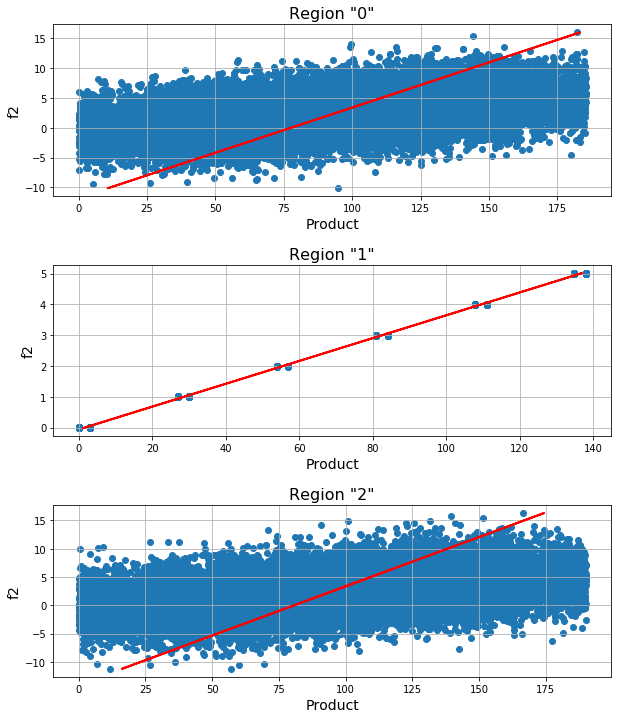

In [20]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(10, 12)

for i in range(len(data)):
    ax[i].scatter(
        target_valid[i],
        features_valid[i].loc[:, 'f2']
        )
    ax[i].plot(models[i].coef_[2]*features_valid[i].loc[:, 'f2'] + models[i].intercept_, features_valid[i].loc[:, 'f2'], color='red', linewidth=2)
    ax[i].grid(True)
    ax[i].set_title(f'Region "{i}"', fontsize=16)
    ax[i].set_xlabel('Product', fontsize=14)
    ax[i].set_ylabel('f2', fontsize=14)

plt.subplots_adjust(hspace=0.4)
plt.show()

Оказывается в регионе "1" f2 у нас меняется дискретно (0,1,2...) и на каждом значении f2 запас сырья может принять только одно из двух значений. Очень любопытное наблюдение.

### Вывод
* Линейная модель плохо подходит для предсказания запасов сырья в регионах "0" и "2". Об этом говорит высокое значение RMSE: около 40 при средних запасах около 90.
* Линейная модель идеально предсказывает запас сырья в регионе "1". Но мы наблюдаем аномалии в значениях признака f2 и целевого признака product.

<a id="earnings"></a>
## 3. Расчёт прибыли

<a id="earnings_1"></a>
### 3.1 Подготовка к расчёту прибыли
**Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины**

In [22]:
WELL_EXPLORE_COUNT = 500
WELL_ELABORATION_COUNT = 200
BARREL_INCOME = 450000
BUDGET_FULL = 10000000000
BUDGET_PER_WELL = BUDGET_FULL / WELL_ELABORATION_COUNT
MINIMAL_PRODUCT_FOR_EARNINGS = BUDGET_PER_WELL / BARREL_INCOME

print(f'Бюджет на разработку скважин в регионе: {BUDGET_FULL}')
print(f'Количество исследуемых скважин в регионе: {WELL_EXPLORE_COUNT}')
print(f'Количество исследуемых скважин для разработки в регионе: {WELL_ELABORATION_COUNT}')
print(f'Доход с одной тысячи баррелей: {BARREL_INCOME}')
print(f'Минимальный доход со скважины для безубыточности: {BUDGET_PER_WELL:.0f}')
print(f'Минимальный запас сырья в скважине для безубыточности: {MINIMAL_PRODUCT_FOR_EARNINGS:.3f}')

Бюджет на разработку скважин в регионе: 10000000000
Количество исследуемых скважин в регионе: 500
Количество исследуемых скважин для разработки в регионе: 200
Доход с одной тысячи баррелей: 450000
Минимальный доход со скважины для безубыточности: 50000000
Минимальный запас сырья в скважине для безубыточности: 111.111


### Вывод
* При средних запасах сырья 92, 68 и 94 в регионах "0", "1" и "2" соответственно минимальный требуемый запас сырья для безубыточности равняется 111. Можем отметить, что нам потребуется найти скважины с запасом сырья сыльно больше среднего

<a id="earnings_2"></a>
### 3.2 Расчёт прибыли и рисков

Функция расчёта прибыли

In [23]:
def wells_earnings(predicted_values=None, selected_count=None, region=None):
    '''Returns revenue of selected wells.'''
    predicted_sorted = predicted_values.sort_values(ascending=False)
    selected_values = target_valid[region][predicted_sorted.index][:selected_count]
    earnings = (selected_values.sum() - MINIMAL_PRODUCT_FOR_EARNINGS*selected_count) * BUDGET_PER_WELL
    return earnings

#### Применим технику Bootstrap для получения распределения средней прибыли по регионам

In [24]:
state = np.random.RandomState(91)
earnings = []
confidence_intervals =[]
for i in range(len(data)):
    values = []
    lower_upper = {}
    for j in range(1000):
        sample = predictions[i].sample(frac=1, replace=True, random_state=state)
        values.append(wells_earnings(sample.iloc[:WELL_EXPLORE_COUNT], WELL_ELABORATION_COUNT, region=i))
    values = pd.Series(values)
    earnings.append(values)
    lower_upper['lower'] = values.quantile(0.025)
    lower_upper['upper'] = values.quantile(0.975)
    confidence_intervals.append(lower_upper)

#### Средняя прибыль, доверительный интервал и вероятность убытков в регионе

In [25]:
RISK_THRESHOLD = 2.5
risk = []

for i in range(len(data)):
    print(f'"{i}" - регион\n\tСредняя прибыль: {earnings[i].mean():.0f}')
    print(f'\tДоверительный интервал: от {confidence_intervals[i]["lower"]:12.0f} до {confidence_intervals[i]["upper"]:12.0f}')
    risk.append((earnings[i] < 0).mean()*100)
    print(f'\tВероятность убытков: {risk[i]}%')
    print()

region = None
best_earnings = 0
for i in range(len(data)):
    if risk[i] < RISK_THRESHOLD and earnings[i].mean() > best_earnings:
        best_earnings = earnings[i].mean()
        region = i

if region:
    print(f'Наибольшая возможная прибыль при риске убытков менее {RISK_THRESHOLD}% в регионе "{region}"')
else:
    print(f'Во всех регионах риск убытков более {RISK_THRESHOLD}%')

"0" - регион
	Средняя прибыль: 48133654190
	Доверительный интервал: от  -6327703974 до 102979279768
	Вероятность убытков: 5.0%

"1" - регион
	Средняя прибыль: 46979959368
	Доверительный интервал: от   3060505137 до  91685591846
	Вероятность убытков: 1.9%

"2" - регион
	Средняя прибыль: 38997069530
	Доверительный интервал: от -17285313556 до  94376825402
	Вероятность убытков: 9.2%

Наибольшая возможная прибыль при риске убытков менее 2.5% в регионе "1"


### Вывод
* Вероятность убытков ниже 2.5% только в регионе "1"

<a id="conclusion"></a>
## 4. Общий вывод
**Обучили модели для каждого региона и предсказали значения на валидационной выборке. Рассчитали минимальный запас сырья в скважине для безубыточности разработки. Применили полученные значения для расчёта прибыли на каждой итерации техники Bootstrap. Посчитали среднюю прибыль, доверительный интервал, вероятность убытков из полученной выборки. На основе полученных данных делаем вывод о необходимости выбора региона "1" для разработки скважин.**